# Artifact removal, Image restoration and Caption Generation using Deep Learning techniques



# BTech Major Project by:


###### Ayush Srivastava , Karaj Khosla, Shivam, Siddharth Chugh, Sukhneet Singh Malhotra 

In [2]:
!git clone https://github.com/divyanshj16/Image-Captioning.git

Cloning into 'Image-Captioning'...
remote: Enumerating objects: 65, done.
remote: Total 65 (delta 0), reused 0 (delta 0), pack-reused 65
Unpacking objects: 100% (65/65), done.


In [3]:
cd Image-Captioning

/content/Image-Captioning


In [5]:
!pip install pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 98kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [7]:

from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from rnn_layers import *
from captioning_solver import CaptioningSolver
from classifiers.rnn import CaptioningRNN
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from scipy.misc.pilutil import imread
from image_utils import image_from_url
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [9]:
 !datasets/get_coco_captioning.sh # uncomment to download

--2021-07-13 14:51:16--  http://cs231n.stanford.edu/coco_captioning.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1035210391 (987M) [application/zip]
Saving to: ‘coco_captioning.zip’

coco_captioning.zip 100%[===================>] 987.25M  11.9MB/s    in 76s     

2021-07-13 14:52:32 (13.0 MB/s) - ‘coco_captioning.zip’ saved [1035210391/1035210391]

Archive:  coco_captioning.zip
   creating: coco_captioning/
  inflating: coco_captioning/coco2014_captions.h5  
  inflating: coco_captioning/coco2014_vocab.json  
  inflating: coco_captioning/train2014_images.txt  
  inflating: coco_captioning/train2014_urls.txt  
  inflating: coco_captioning/train2014_vgg16_fc7.h5  
  inflating: coco_captioning/train2014_vgg16_fc7_pca.h5  
  inflating: coco_captioning/val2014_images.txt  
  inflating: coco_captioning/val2014_urls.txt  
  inf

In [11]:
data = load_coco_data(pca_features=True) 


for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 39.716144
(Iteration 21 / 100) loss: 22.291342
(Iteration 31 / 100) loss: 6.827686
(Iteration 41 / 100) loss: 2.172634
(Iteration 51 / 100) loss: 0.546785
(Iteration 61 / 100) loss: 0.209259
(Iteration 71 / 100) loss: 0.102937
(Iteration 81 / 100) loss: 0.082677
(Iteration 91 / 100) loss: 0.047413


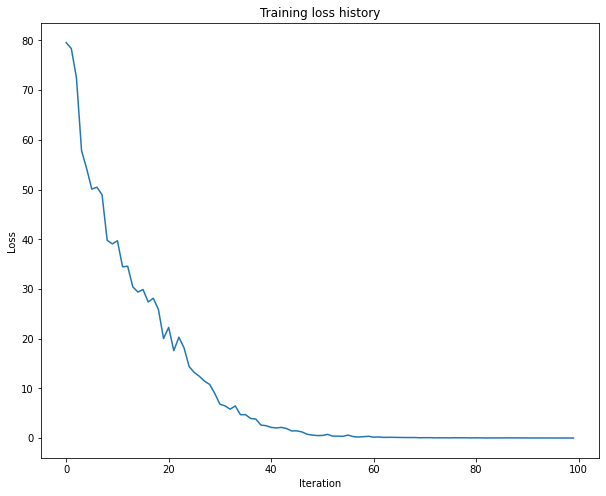

In [12]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 7e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

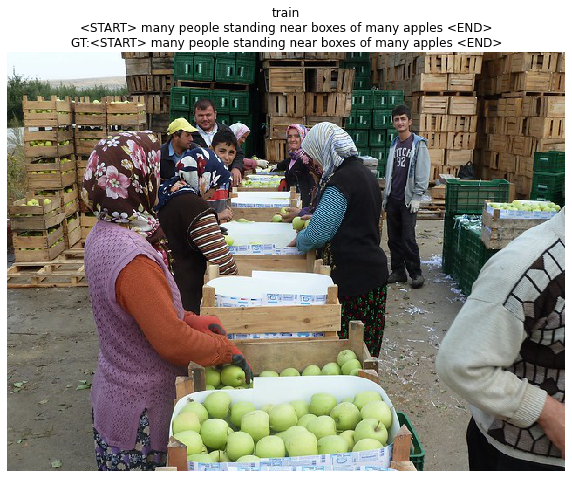

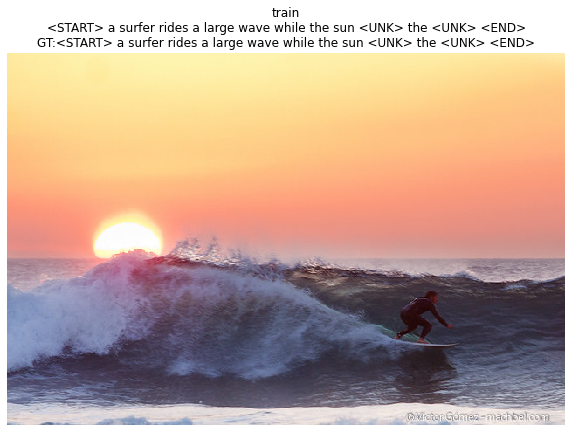

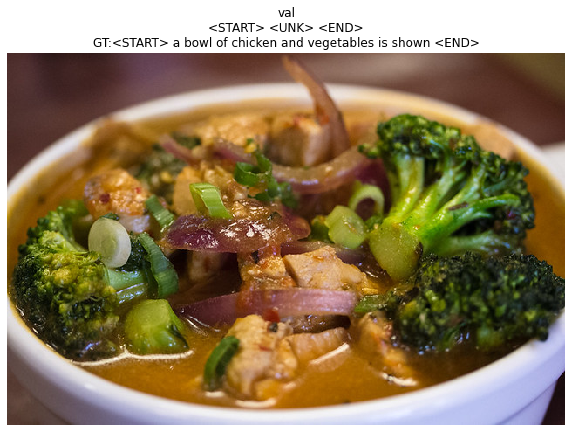

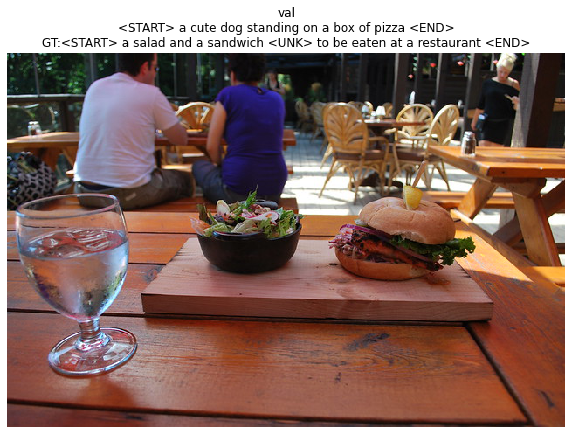

In [19]:
from image_utils import image_from_url
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

In [ ]:
def BLEU_score(gt_caption, sample_caption):
    
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [ ]:
np.random.seed(231)

data = load_coco_data()

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, data,
           update_rule='adam',
           num_epochs=25,
           batch_size=128,
           optim_config={
             'learning_rate': 7e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=100,
         )
lstm_solver.train()


plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 78150) loss: 76.893173
(Iteration 101 / 78150) loss: 33.125469
(Iteration 201 / 78150) loss: 30.169975
(Iteration 301 / 78150) loss: 30.451328
(Iteration 401 / 78150) loss: 28.824917
(Iteration 501 / 78150) loss: 29.590760
(Iteration 601 / 78150) loss: 29.198437
(Iteration 701 / 78150) loss: 28.940937
(Iteration 801 / 78150) loss: 28.579056
(Iteration 901 / 78150) loss: 28.550907
(Iteration 1001 / 78150) loss: 27.965242
(Iteration 1101 / 78150) loss: 27.529464
(Iteration 1201 / 78150) loss: 28.094898
(Iteration 1301 / 78150) loss: 26.410408
(Iteration 1401 / 78150) loss: 28.764663
(Iteration 1501 / 78150) loss: 26.738010
(Iteration 1601 / 78150) loss: 27.313256
(Iteration 1701 / 78150) loss: 26.804863
(Iteration 1801 / 78150) loss: 26.031640
(Iteration 2201 / 78150) loss: 26.283177
(Iteration 2301 / 78150) loss: 28.290825
(Iteration 2401 / 78150) loss: 26.874582
(Iteration 2501 / 78150) loss: 28.184986
(Iteration 2601 / 78150) loss: 26.213184
(Iteration 2701 / 78150) los

KeyboardInterrupt: 

In [ ]:
import nltk

evaluate_model(small_lstm_model)

Average BLEU score for train: 0.177228
Average BLEU score for val: 0.174437


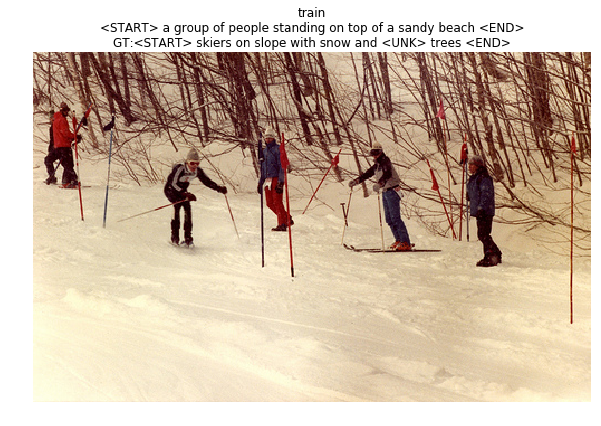

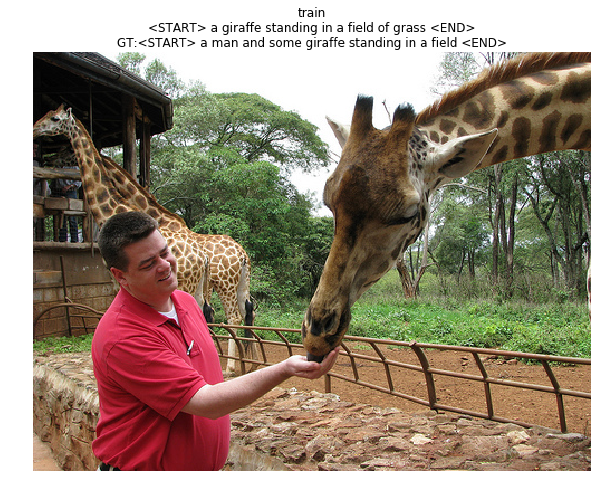

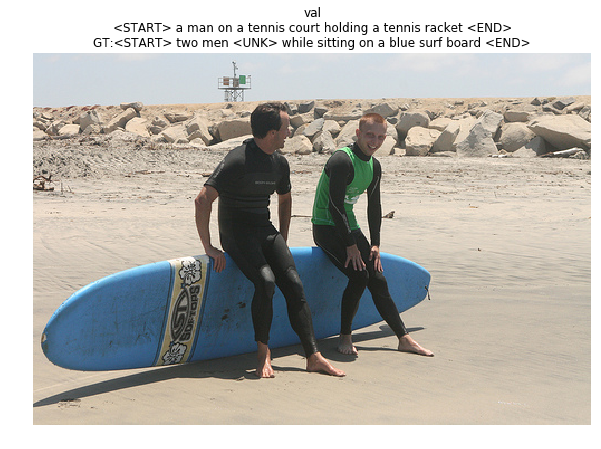

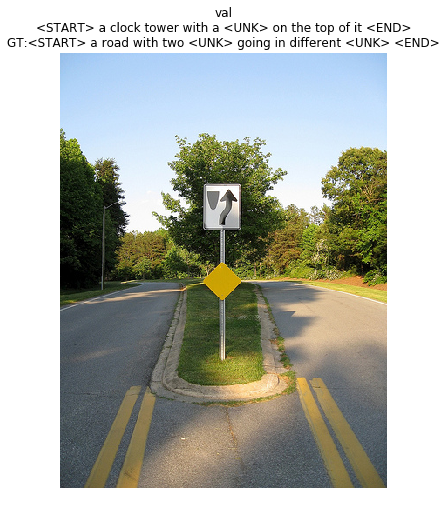

In [ ]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()